<a href="https://colab.research.google.com/github/mishty-ray/marked-beetle-analysis-1/blob/main/EfficientB7_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Get modified images thanks to Jules's preprocessing 
filenames = os.listdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")
filenames[:4]


['PaperedControl40v.tif',
 'PaperedControl41v.tif',
 'PaperedControl41v_light.tif',
 'PaperedControl41d.tif']

In [5]:
#Only include papered or nopapered, throw out pinkpapiermache and light images
train_images=[]
for filename in filenames:
    if 'light' not in filename and (filename.startswith('Papered') or filename.startswith('NoPapered')):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") 


Number of Train images: 757


In [6]:
#Potentially use this filenames for prediction, these are the trapped beetles and we are trying to see if they're marked
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [7]:
#Categories contains a list of two classes - marked and unmarked. This is an array indexed by filenames and each index corresponds to whether the filename corresponds with a marked or an unmarked beetle
categories = []
for filename in train_images:
    if filename.startswith('Papered'):
    #if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [8]:
#creating a dataframe that stores filenames and corresponding categories
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df.head()

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked


In [9]:
df.groupby('category').size()

category
marked      479
unmarked    278
dtype: int64

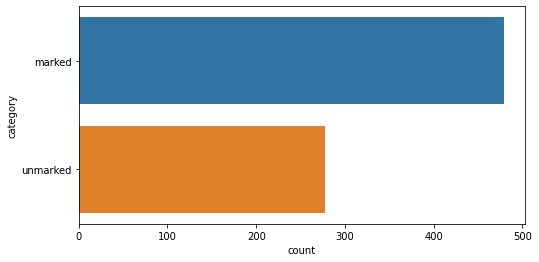

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", filenames[0]))
image.shape

(1944, 2592, 3)

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
def threscrop(img):
  #convert to grayscale and apply adaptive thresholding
  grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #return thresh

  #detect edges and crop the image
  canny = cv2.Canny(thresh, 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  #cropped_img = img[y1:y2, x1:x2]
  cropped_img = cv2.resize(thresh[y1:y2, x1:x2], (600,600))
  cropped_img = cropped_img.reshape(cropped_img.shape + (1,))



  return cropped_img

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
def crop(img):#not running this time

  blurred = cv2.blur(img, (3,3))
  canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

## crop the region
  cropped = img[y1:y2, x1:x2]
  resized=cv2.resize(cropped, (600,600))
  #cv2.imwrite("cropped.png", cropped)
  return resized

  #tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
  #cv2.imshow("tagged", tagged)
  #cv2.waitKey()

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
cv2_imshow(threscrop(image))
threscrop(image).shape
#not running this time

In [ ]:
#no need to run this cell as the data we have has already been converted to grayscale and cropped
cv2_imshow(crop(image));
crop(image).shape;
#not running this time

In [ ]:
#function to plot the images of a sample of the beetles
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
#taking a random sample of our dataframe 
tmp_df = df.sample(9)
tmp_df

,filename,category
71,PaperedControl76v.tif,marked
416,NoPaperedGreen70d.tif,unmarked
286,PaperedTransparent104d.tif,marked
246,PaperedTransparent84d.tif,marked
149,PaperedTransparent36v.tif,marked
322,NoPaperedGreen35d.tif,unmarked
248,PaperedTransparent85d.tif,marked
403,NoPaperedGreen64v.tif,unmarked
728,PaperedControl26d.tif,marked


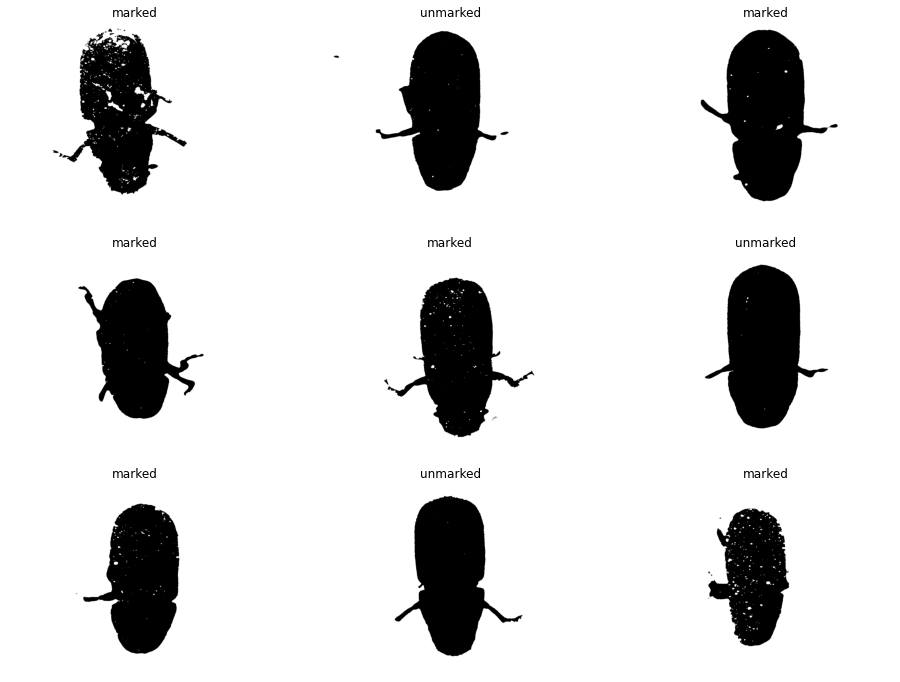

In [ ]:
#plotting the images by calling the function with the sample subset as argument 
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [ ]:
#Creating training and validation data out of our dataframe with an 80-20 split . This wil be an array of filenames or indices
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

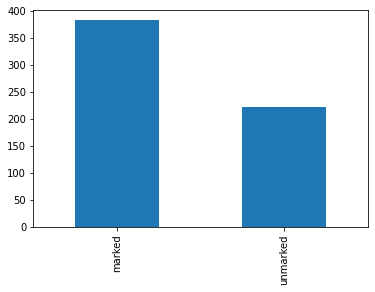

In [ ]:
train_df['category'].value_counts().plot.bar()

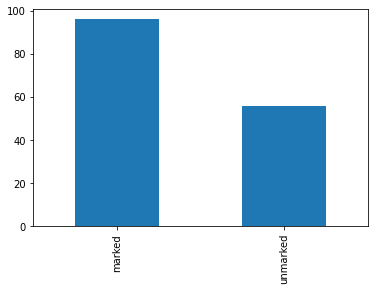

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [15]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [ ]:
#Preprocessing the data for the training set with no/default preprocessing function.
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')


In [ ]:
#Default/no preprocessing for the validation set 
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
#train_set will help with generating valid training sets using the information in datagen_train 
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
#validate_set will help with generating valid training sets using the information in datagen_val 
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE))

    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

258088960/258076736 [==============================] - 5s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
____________________

In [ ]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/bestmodel_EB7_cropped.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
  
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/mostrecentmodel_EB7_cropped.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/50
40/40 [==============================] - 1551s 38s/step - loss: 1.1562 - accuracy: 0.7339 - val_loss: 0.7220 - val_accuracy: 0.6400


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
40/40 [==============================] - 1544s 39s/step - loss: 1.0076 - accuracy: 0.7783 - val_loss: 0.5382 - val_accuracy: 0.7200
Epoch 3/50
40/40 [==============================] - 1562s 39s/step - loss: 0.8317 - accuracy: 0.7949 - val_loss: 0.4842 - val_accuracy: 0.7867
Epoch 4/50
40/40 [==============================] - 1554s 39s/step - loss: 0.6601 - accuracy: 0.8441 - val_loss: 0.4586 - val_accuracy: 0.7733
Epoch 5/50
40/40 [==============================] - 1584s 40s/step - loss: 0.7889 - accuracy: 0.8136 - val_loss: 0.4814 - val_accuracy: 0.7800
Epoch 6/50
40/40 [==============================] - 1583s 40s/step - loss: 0.6541 - accuracy: 0.8203 - val_loss: 0.4758 - val_accuracy: 0.7667

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/50
40/40 [==============================] - 1618s 41s/step - loss: 0.5411 - accuracy: 0.8508 - val_loss: 0.4963 - val_accuracy: 0.7667
Restoring model weights from the end of the best epoch.
Epoc

In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8508474826812744
Val_Cat-Acc:  0.7866666913032532


In [3]:
from keras.models import load_model
resultmodel=load_model("/content/drive/MyDrive/bestmodel_EB7_cropped.h5")

In [ ]:
resultmodel.save("/content/drive/MyDrive/model_threscrop_epoch5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_threscrop_epoch5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


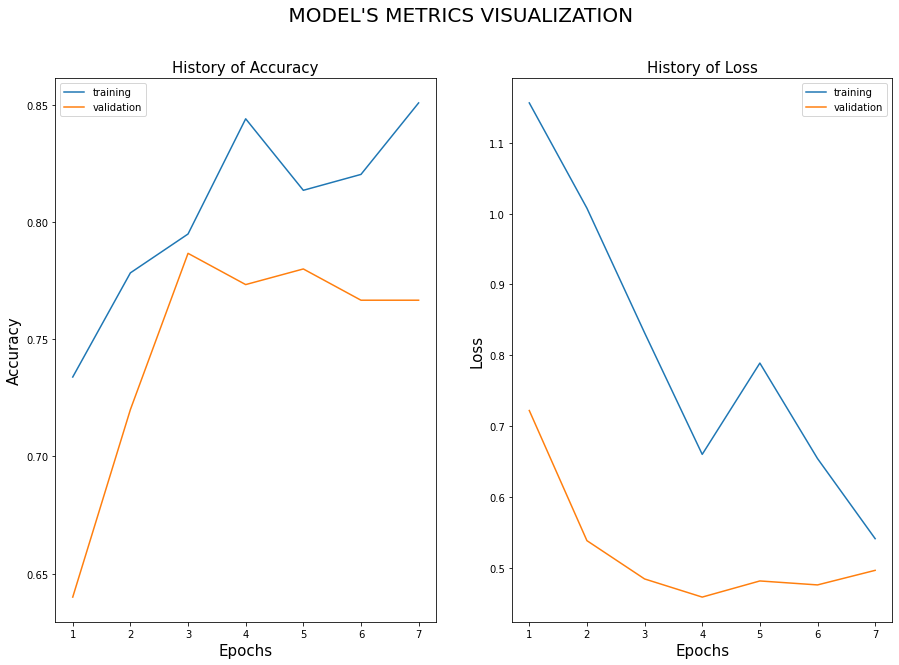

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
import keras

final_model = keras.models.load_model('best_model.h5')

In [11]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
49,PaperedControl65v.tif,marked
197,PaperedTransparent60v.tif,marked
136,PaperedTransparent29d.tif,marked
594,PaperedMixed24d.tif,marked
434,NoPaperedGreen79d.tif,unmarked
481,NoPaperedMixed18v.tif,unmarked
741,PaperedControl33v.tif,marked
108,PaperedTransparent15v.tif,marked
615,PaperedMixed35v.tif,marked
47,PaperedControl64v.tif,marked


In [12]:
nb_samples = tmp_df1.shape[0]

In [16]:

test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)
 #preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
  ##                 width_shift_range = 0.2,
    ##               shear_range = 0.2,
      #              zoom_range = 0.2,
       #             horizontal_flip = True,
        #            vertical_flip = True,
         #           fill_mode = 'nearest')

Found 10 validated image filenames.


In [17]:
predict = resultmodel.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [18]:


tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1



,filename,category,prediction
49,PaperedControl65v.tif,marked,unmarked
197,PaperedTransparent60v.tif,marked,unmarked
136,PaperedTransparent29d.tif,marked,marked
594,PaperedMixed24d.tif,marked,marked
434,NoPaperedGreen79d.tif,unmarked,unmarked
481,NoPaperedMixed18v.tif,unmarked,marked
741,PaperedControl33v.tif,marked,marked
108,PaperedTransparent15v.tif,marked,marked
615,PaperedMixed35v.tif,marked,marked
47,PaperedControl64v.tif,marked,marked


In [19]:
to_samples = df.shape[0]

In [20]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [22]:
predict = resultmodel.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [24]:
df['prediction'] = np.argmax(predict, axis=-1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

,filename,category,prediction
0,PaperedControl40v.tif,marked,marked
1,PaperedControl41v.tif,marked,marked
2,PaperedControl41d.tif,marked,marked
3,PaperedControl42v.tif,marked,marked
4,PaperedControl42d.tif,marked,marked
...,...,...,...
752,PaperedControl38v.tif,marked,marked
753,PaperedControl38d.tif,marked,marked
754,PaperedControl39v.tif,marked,marked
755,PaperedControl39d.tif,marked,marked


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

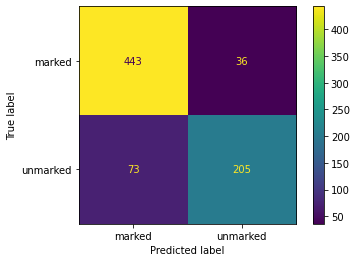

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")


In [29]:
cm

array([[443,  36],
       [ 73, 205]])

In [33]:
final_metric = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
final_metric

0.8560105680317041